# Predicting Volatility and Sign of S&P Returns using LSTM

## Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, root_mean_squared_error, mean_absolute_error

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
df = pd.read_csv('monthly_FRED-MD_2024-12_processed.csv')
#df = df[["RPI", "IPFUELS", "PAYEMS", "UNRATE", "FEDFUNDS", "TB3MS", "CPIAUCSL", "HOUST", "GS10", "sign"]]

Applying PCA might help mitigate the multicollinearity of the data, but makes interpretation at the end harder.

In [4]:
# from sklearn.decomposition import PCA
# X = df.drop(columns=["sign", "volatility"]).values
# feature_names = list(df.drop(columns=["sign", "volatility"]).columns)
# pca = PCA()
# pca.fit(X)
# explained = pca.explained_variance_ratio_
# cum_explained = np.cumsum(explained)

# # number of components to explain 95% variance
# k95 = int(np.searchsorted(cum_explained, 0.95) + 1)
# print(f"Components to explain 95% variance: {k95} / {X.shape[1]}")

# X_pca_all = pca.transform(X)
# X_pca = X_pca_all[:, :k95]

# # optional: dataframe of PCs (index aligns with original df)
# pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
# pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)

# df = pd.concat([pca_df, df[["sign", "volatility"]]], axis=1)

# print(pca_df.head())

## Hyperparameter

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [6]:
NUMBER_OF_LAGS = 10
TRAIN_RATIO = 0.8
HIDDEN_DIM = 16
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 3e-4
BATCH_SIZE = 64
EPOCHS = 50
CLASS_THRESHOLD = 0.5
#n_pos, n_neg =df["sign"].value_counts()
#POS_WEIGHT = torch.tensor([n_neg / n_pos], dtype=torch.float).to(device)


In [7]:
# Keep only numeric features (drop target)
numeric = df.select_dtypes(include=[np.number]).copy()
X_all = numeric.drop(columns=["sign", "volatility"]).values
y_sign = numeric["sign"].astype(int).values
y_volatility = numeric["volatility"].astype(float).values

In [8]:
# Create sliding-window sequences
def create_sequences(X, y_sign, y_vola, window):
    Xs, ys, yv = [], [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i, :])
        ys.append(y_sign[i])
        yv.append(y_vola[i])
    return np.array(Xs), np.array(ys), np.array(yv)

X_seq, y_seq, yv_seq = create_sequences(X_all, y_sign, y_volatility, NUMBER_OF_LAGS)

In [9]:
print(f"Shape X: {X_seq.shape}")
print(f"Shape sign: {y_seq.shape}")
print(f"Shape volatility: {yv_seq.shape}")

Shape X: (779, 10, 113)
Shape sign: (779,)
Shape volatility: (779,)


## Train-Test Split

In [10]:
train_size = int(len(X_seq) * TRAIN_RATIO)
X_train = X_seq[:train_size]; X_test = X_seq[train_size:]
ys_train = y_seq[:train_size]; ys_test = y_seq[train_size:]
yv_train = yv_seq[:train_size]; yv_test = yv_seq[train_size:]

In [11]:
# Torch datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
ys_train_t = torch.tensor(ys_train, dtype=torch.float32).unsqueeze(1).to(device)
yv_train_t = torch.tensor(yv_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_t, ys_train_t, yv_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

## LSTM Model

In [12]:
class LSTMDoubleOutput(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 neurons as output - one for sign, one for volatility
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)  # logits (use BCEWithLogitsLoss)

input_dim = X_train.shape[2]
model = LSTMDoubleOutput(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS).to(device)
criterion_sign = nn.BCEWithLogitsLoss()
criterion_volatility = nn.MSELoss()
lambda_volatility = 0.5  # weight for volatility loss

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Training Loop

As there two output neurons, we need two loss functions. These are added and the sum of these losses (=Total Loss) is minimized. The parameter lambda_volatilty can be set to adjust the weight of the volatility loss. E.g. setting it to 0.5 means that a 0.1 decrease of loss in sign is twice as valuable as a 0.1 decrease in loss for volatility.

In [13]:
model.train()
pre_logits = []
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    total_sign_loss = 0.0
    total_vol_loss = 0.0
    n = 0
    for Xb, yb_sign, yb_vol in train_loader:
        optimizer.zero_grad()
        # output of neural network are values for sign and volatility
        out = model(Xb)                   
        sign_logit = out[:, 0:1]
        if epoch == EPOCHS:
            pre_logits.append(sign_logit)
        vol_pred_z = out[:, 1:2]
        loss_sign = criterion_sign(sign_logit, yb_sign)
        loss_vol = criterion_volatility(vol_pred_z, yb_vol)
        loss = loss_sign + lambda_volatility * loss_vol
        loss.backward()
        optimizer.step()
        batch_n = Xb.size(0)
        # Multiply by batch size as the last batch might be smaller because train_size 
        # is not necessarily divisible by BATCH_SIZE
        total_loss += loss.item() * batch_n
        total_sign_loss += loss_sign.item() * batch_n
        total_vol_loss += loss_vol.item() * batch_n
        n += batch_n
    total_loss /= n
    total_sign_loss /= n
    total_vol_loss /= n
    if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
        print(f"Epoch {epoch}/{EPOCHS} - loss: {total_loss:.4f} | sign_loss: {total_sign_loss:.4f} | vol_loss: {total_vol_loss:.6f}")


Epoch 1/50 - loss: 693.0292 | sign_loss: 0.6847 | vol_loss: 1384.689068
Epoch 10/50 - loss: 666.9688 | sign_loss: 0.6759 | vol_loss: 1332.585873
Epoch 20/50 - loss: 609.1384 | sign_loss: 0.6753 | vol_loss: 1216.926279
Epoch 30/50 - loss: 573.7408 | sign_loss: 0.6743 | vol_loss: 1146.133115
Epoch 40/50 - loss: 546.7747 | sign_loss: 0.6737 | vol_loss: 1092.201956
Epoch 50/50 - loss: 526.7840 | sign_loss: 0.6736 | vol_loss: 1052.220833


In [14]:
pre_logits = torch.cat(pre_logits, dim=0).detach().cpu().numpy()
logits = (1 / (1 + np.exp(-pre_logits)))  # sigmoid

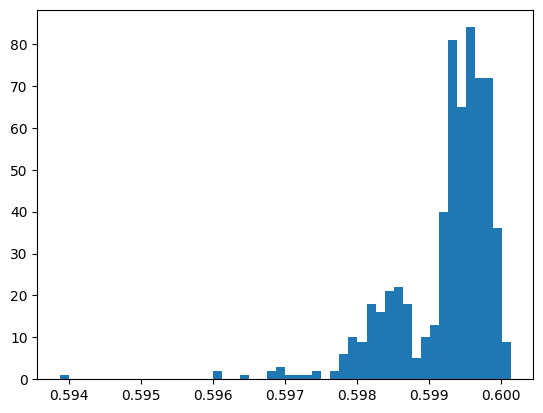

In [15]:
# plot logits distribution for the last epoch of TRAINING data
import matplotlib.pyplot as plt
plt.hist(logits, bins=50)
plt.show()

## Evaluation

Lastly, the model predicts sign and volatility with the parameters learned during the training before. The binary sign prediction is obtained by passing the output values through a sigmoid layer to get probabilities between 0 and 1. Based on the CLASS_THRESHOLD, these probabilites are converted to 0 or 1.

In [16]:
model.eval()
with torch.no_grad():
    out_test = model(X_test_t)
    sign_logits_test = out_test[:, 0].cpu().numpy()
    sign_probs = torch.sigmoid(out_test[:, 0:1]).cpu().numpy().squeeze()
    sign_preds = (sign_probs > CLASS_THRESHOLD).astype(int)
    vol_preds = out_test[:, 1].cpu().numpy().squeeze()

In [17]:
# classification metrics
acc = accuracy_score(ys_test, sign_preds)
print(f"Test accuracy (sign): {acc:.4f}")
print("Classification report (sign):")
print(classification_report(ys_test, sign_preds, digits=4))

# regression metrics for volatility
mse_vol = mean_squared_error(yv_test, vol_preds)
rmse_vol = root_mean_squared_error(yv_test, vol_preds)
mae = mean_absolute_error(yv_test, vol_preds)
print(f"Volatility MSE (original units): {mse_vol:.6f}")
print(f"Volatility RMSE (original units): {rmse_vol:.6f}")
print(f"Volatility MAE (original units): {mae:.6f}")

Test accuracy (sign): 0.6923
Classification report (sign):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        48
           1     0.6923    1.0000    0.8182       108

    accuracy                         0.6923       156
   macro avg     0.3462    0.5000    0.4091       156
weighted avg     0.4793    0.6923    0.5664       156

Volatility MSE (original units): 935.848571
Volatility RMSE (original units): 30.591642
Volatility MAE (original units): 29.156005


C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

In [18]:
def count_parameters(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    print(f"Total params: {total:,} | Trainable params: {trainable:,}")

count_parameters(model)

print(f"Data points: {df.shape[0]*df.shape[1]}")

Total params: 10,594 | Trainable params: 10,594
Data points: 90735


Interpreting the output with Shap values

C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  2%|▏         | 1/50 [00:00<00:06,  7.52it/s]C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
 12%|█▏        | 6/50 [00:00<00:05,

          variable  mean_abs_shap
16       IPB51222S   1.756201e+25
80         T10YFFM   1.756201e+25
47           HOUST   2.748779e+09
82          BAAFFM   9.268325e+08
103          PCEPI   3.026103e+08
13          IPDMAT   2.080741e+08
19             HWI   7.201474e-04
69           TB6MS   1.523276e-05
92          PPICMM   6.296361e-06
75       COMPAPFFx   5.939493e-06
54         BUSINVx   5.096445e-06
8          IPCONGD   4.863854e-06
60        TOTRESNS   4.509784e-06
84         EXJPUSx   4.475617e-06
62        BUSLOANS   4.416038e-06
110    DTCOLNVHFNM   4.374286e-06
44   CES0600000007   4.154099e-06
50          HOUSTS   3.753851e-06
59        BOGMBASE   3.477518e-06
3        CMRMTSPLx   3.403633e-06


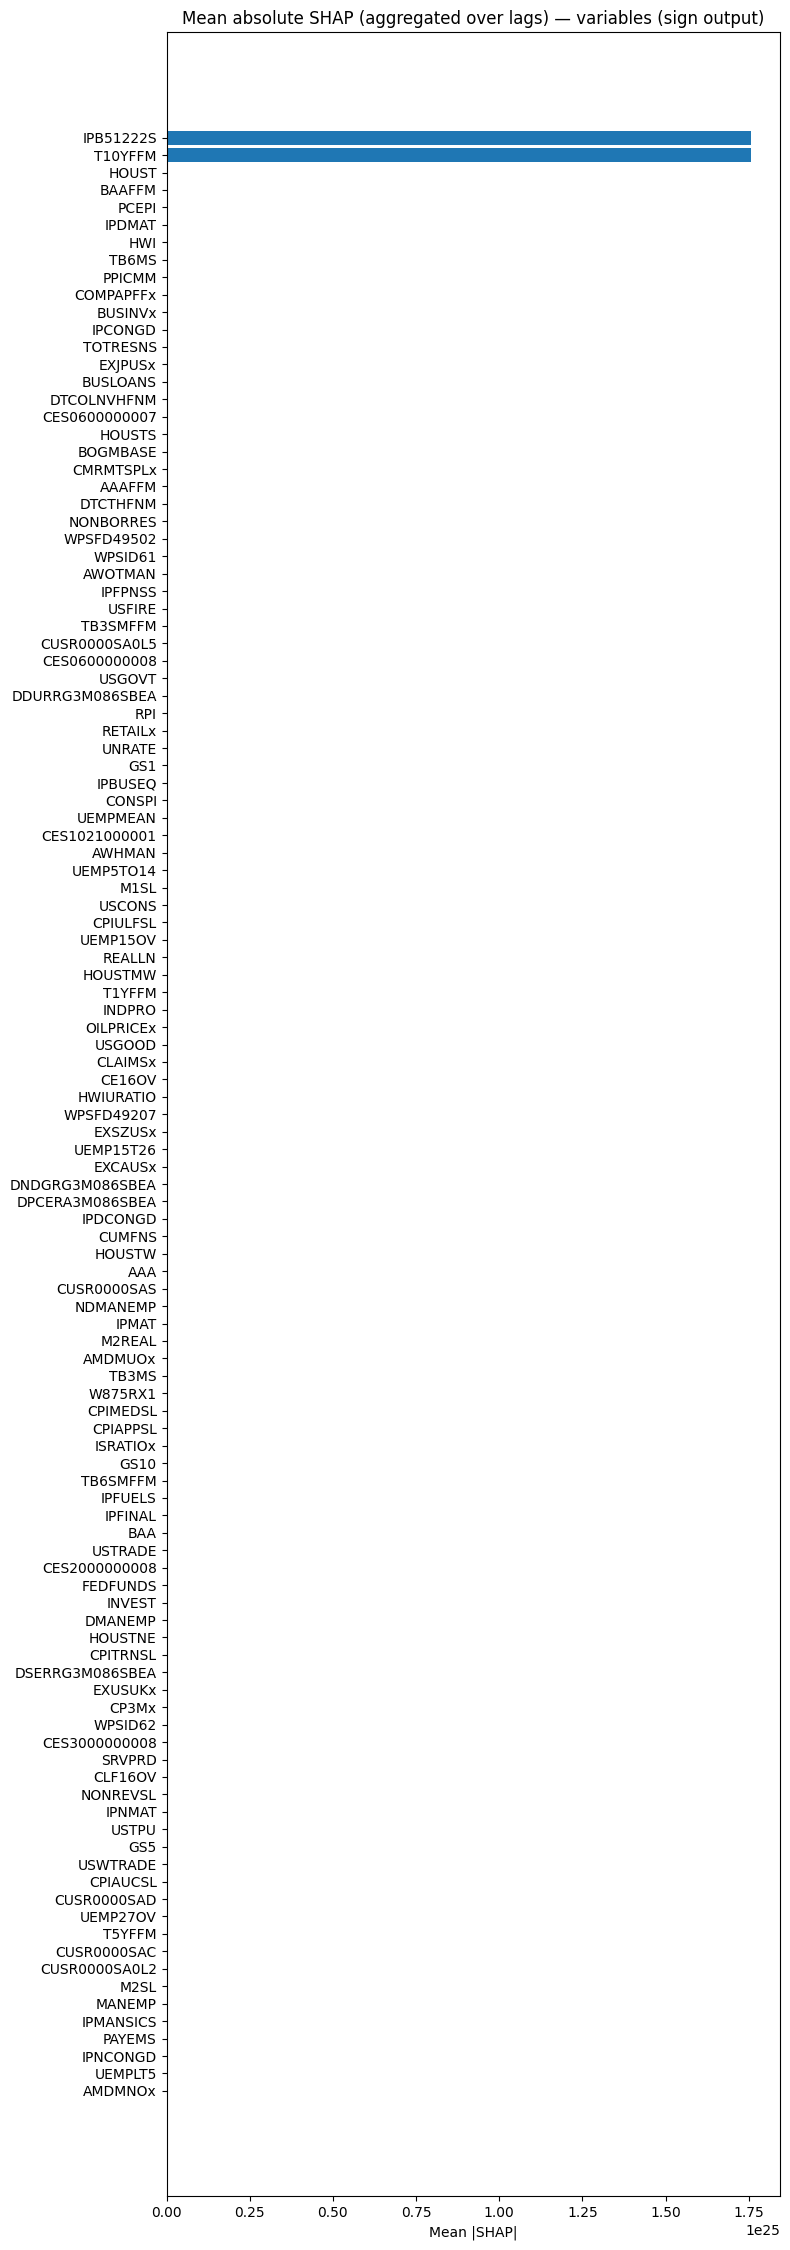

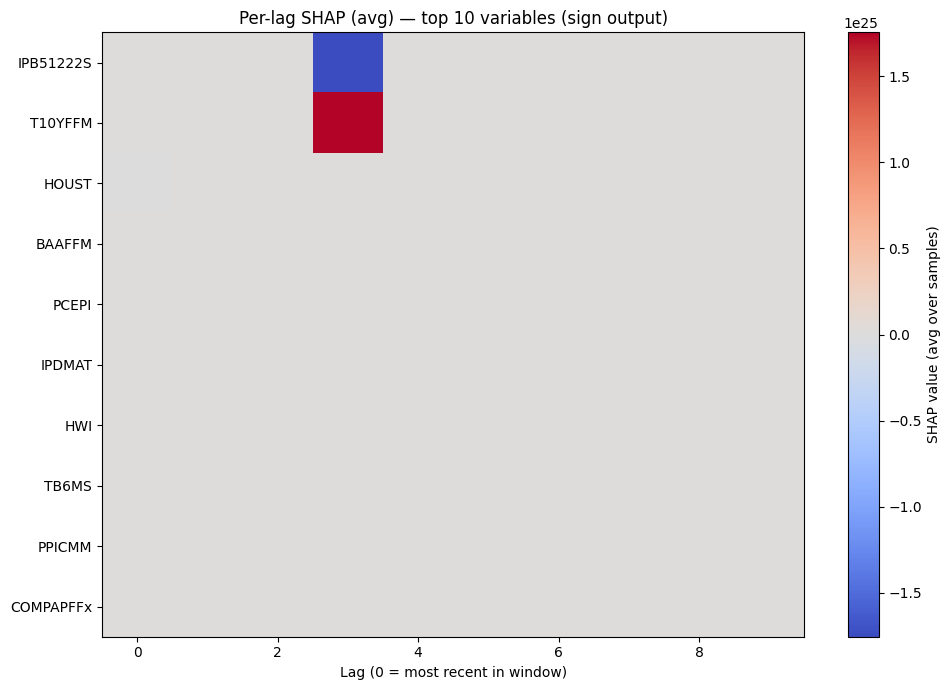

In [19]:
import shap
import matplotlib.pyplot as plt

# configure sizes (reduce for speed)
N_BACKGROUND = min(100, X_train.shape[0])
N_EXPLAIN = min(50, X_test.shape[0])
NSAMPLES = 100  # KernelExplainer samples (increase for accuracy)

# feature names (original numeric columns without 'sign' and 'volatility')
feature_names = list(numeric.drop(columns=["sign", "volatility"]).columns)
input_dim = X_train.shape[2]
window = NUMBER_OF_LAGS

# prepare background and explain matrices (flatten time axis)
Xb = X_train[:N_BACKGROUND].reshape(N_BACKGROUND, -1)
Xexp = X_test[:N_EXPLAIN].reshape(N_EXPLAIN, -1)

# prediction function for SHAP: expects flattened numpy array -> returns 1D vector (sign probability)
def predict_sign_proba(X_flat):
    # X_flat shape: (m, window*input_dim) or (window*input_dim,) for single sample
    X = np.array(X_flat).reshape(-1, window, input_dim)
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        out = model(X_t)                  # (m, 2) or (m, n_outputs)
        sign_logit = out[:, 0:1]          # keep only sign head
        sign_prob = torch.sigmoid(sign_logit).cpu().numpy().squeeze()
    # ensure returned shape is (m,) for KernelExplainer
    return np.asarray(sign_prob).ravel()

# create explainer; use background Xb (numpy)
explainer = shap.KernelExplainer(predict_sign_proba, Xb)

# compute shap values for sign output
shap_vals_raw = explainer.shap_values(Xexp, nsamples=NSAMPLES)

# normalize shap output to array of shape (n_samples, n_features_flat)
if isinstance(shap_vals_raw, list):
    # KernelExplainer may return a list (one per model output/class); we only expect sign -> take first sensible element
    # possible shapes: [ (n_samples, n_features) ] or list of arrays -> take first
    shap_candidate = shap_vals_raw[0]
else:
    shap_candidate = shap_vals_raw
shap_flat = np.array(shap_candidate)

# sanity check
n_features_flat = window * input_dim
if shap_flat.ndim != 2 or shap_flat.shape[1] != n_features_flat:
    raise ValueError(f"Unexpected SHAP shape {shap_flat.shape}, expected (n_samples, {n_features_flat})")

# reshape to (n_samples, window, input_dim)
shap_arr = shap_flat.reshape(shap_flat.shape[0], window, input_dim)

# aggregate absolute contributions by variable (sum over lags, then mean over samples)
per_var_importance = np.mean(np.sum(np.abs(shap_arr), axis=1), axis=0)  # length = input_dim

# DataFrame and bar plot
imp_df = pd.DataFrame({
    "variable": feature_names,
    "mean_abs_shap": per_var_importance
}).sort_values("mean_abs_shap", ascending=False)

print(imp_df.head(20))

plt.figure(figsize=(8, max(4, 0.2 * len(imp_df))))
plt.barh(imp_df['variable'].iloc[::-1], imp_df['mean_abs_shap'].iloc[::-1])
plt.title('Mean absolute SHAP (aggregated over lags) — variables (sign output)')
plt.xlabel('Mean |SHAP|')
plt.tight_layout()
plt.show()

# Optional: per-lag heatmap for top K variables
TOP_K = 10
top_vars = imp_df['variable'].iloc[:TOP_K].values
top_idx = [feature_names.index(v) for v in top_vars]

# average SHAP across samples for chosen vars, shape (window, TOP_K)
shap_time_top = np.mean(shap_arr[:, :, top_idx], axis=0)  # (window, TOP_K)

plt.figure(figsize=(10, 4 + 0.3 * window))
plt.imshow(shap_time_top.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='SHAP value (avg over samples)')
plt.yticks(range(len(top_vars)), top_vars)
plt.xlabel('Lag (0 = most recent in window)')
plt.title(f'Per-lag SHAP (avg) — top {TOP_K} variables (sign output)')
plt.tight_layout()
plt.show()
# ...existing code...